# Classification - Bank Marketing

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Classification labels are unbalanced. Might be worth considering running through these metrics and techniques: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/. Also: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [3]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor
from model.model_creation import create_fit_model

Sensitivity module imported
Dataset converter module imported
Metadata module imported
Infidelity module imported
Feature columns module imported


In [4]:
# Import data from csv
csv_file = 'data/classification-bank/bank-full.csv'
dataframe = pd.read_csv(csv_file, index_col=False, sep=';')

In [5]:
# Convert the Y value to 1 or 0
dataframe['y_binary'] = np.where(dataframe['y']=='yes', 1, 0)
dataframe.drop(['y'], axis=1, inplace=True)

In [6]:
# Convert day to strings (as this is really a categorical column):
dataframe['day'] = dataframe['day'].astype(str)

In [7]:
dataframe['day'][0]

'5'

In [8]:
# Sanity check
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y_binary
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [9]:
# Import metadata
import json
file = open('metadata.json')
metadata = json.load(file)

# Check this list aligns with the dataframe headers
df_headers = [f for f in dataframe]
for index, metadata_header in enumerate(metadata, start=0):
    assert(df_headers[index] == metadata_header['name'])
print('Confirm metadata aligns with dataframe')

Confirm metadata aligns with dataframe


In [10]:
# Append indexes to metadata
metadata = append_indices(metadata)
    
# Append baselines to metadata
    # Numerical: mean
    # Ordinal: mid-point of all values
    # Nominal: mode
metadata = append_baselines(metadata, dataframe)

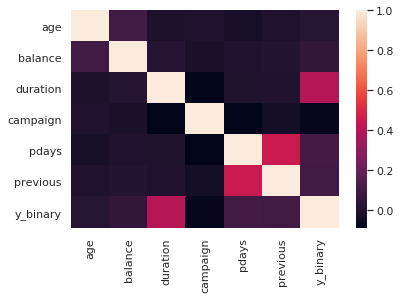

In [11]:
# Plot correlation matrix for numerical variables
# We can see [call] duration seems to have an impact on whether a loan is taken - this feels reasonable
corr = dataframe.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [12]:
# Split data (note this randomises the split so no stratification issues)
train_df, test_df = train_test_split(dataframe, test_size=0.2)
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y_binary
39863,29,management,single,tertiary,no,307,yes,no,cellular,2,jun,690,1,-1,0,unknown,1
31315,32,management,married,tertiary,no,8929,no,no,cellular,11,mar,126,1,-1,0,unknown,1
39894,29,self-employed,single,tertiary,no,871,yes,no,cellular,2,jun,310,1,-1,0,unknown,0
42470,66,retired,married,unknown,no,2540,no,no,telephone,10,dec,441,2,156,1,other,1
677,35,technician,married,secondary,no,-131,yes,no,unknown,6,may,467,2,-1,0,unknown,0


In [13]:
batch_size = 100
train_ds = convert_df_dataset(train_df, 'y_binary', batch_size=batch_size)
test_ds = convert_df_dataset(test_df, 'y_binary', shuffle=False, batch_size=batch_size)

In [14]:
# Reset our feature columns
feature_columns = []

In [15]:
# Normalize and add numeric columns
# From: https://towardsdatascience.com/how-to-normalize-features-in-tensorflow-5b7b0e3a4177

# Get list of numeric columns
numeric_features_to_use = get_feature_names_of_type('numerical', metadata)

# Calculate mean and standard deviation (to feed into normalisation)
normalization_parameters = get_normalization_parameters(train_df, numeric_features_to_use)

# Get feature columns with built-in normaliser; add to list main list of columns
numeric_feature_columns = create_numeric_columns(train_df, numeric_features_to_use, normalization_parameters)
feature_columns += numeric_feature_columns

In [16]:
# Add indicator (one-hot) columns for categorical fields

nominal_features_to_use = get_feature_names_of_type('nominal', metadata)
ordinal_features_to_use = get_feature_names_of_type('ordinal', metadata)

categorical_features_to_use = nominal_features_to_use + ordinal_features_to_use

categorical_feature_columns = create_categorical_columns(train_df, categorical_features_to_use)
feature_columns += categorical_feature_columns

In [17]:
# Sanity check of feature columns
print(len(feature_columns))

15


In [18]:
# Use our feature columns to create an input layer (i.e. a mapping from the tf.data file)
input_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer

In [19]:
# Create our model
model = tf.keras.Sequential([
  input_layer,
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(1, activation='sigmoid')
])


In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


In [21]:
# Compile and train our model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)



In [22]:
example_model, example_history = create_fit_model(train_ds, input_layer, METRICS, epochs=3, verbose=0)

In [23]:
# Evaluate the overall accuracy of our model using the test set
loss, accuracy, precision, recall, auc = model.evaluate(test_ds)
print("Test set accuracy", accuracy)

# Calculate percentage of y=0 values for comparison
y_zero = test_df['y_binary'].value_counts()[0]
y_one = test_df['y_binary'].value_counts()[1]
print(y_zero / (y_zero + y_one))

91/91 [==============================] - 3s 15ms/step - loss: 0.7887 - accuracy: 0.8120 - precision: 0.2836 - recall: 0.3037 - auc: 0.7431
Test set accuracy 0.7447524070739746
0.8834457591507243


In [24]:
# Select an index value to predict/explain
index_to_explain = 388

In [25]:
# Allows us to predict a value for a specific instance
def predict_wrapper(model, instance, feature_names):
    input_tensor = convert_numpy_tensor(instance, feature_names)
    return model.predict(input_tensor)

feature_names = get_feature_names(metadata)
instance = convert_dataframe_numpy(dataframe, index_to_explain)
predict_wrapper(example_model, instance, feature_names)

array([[0.01971865]], dtype=float32)

In [26]:
# Set optimal constants for SHAP explanations
NUM_REFERENCE_VALUES = 50
NUM_PERTURBATIONS = 500

# SHAP expects to be passed a prediction function that just takes an instance
def shap_predictor_factory(feature_names, model):
    def predictor(instance):
        input_tensor = convert_numpy_tensor(instance, feature_names)
        return model.predict(input_tensor)
    return predictor

# Gets a SHAP explanainer
def get_explainer(predict_wrapper, dataframe_local, num_reference_values=50):
    # This never takes significant time - just calculating background values
    return shap.KernelExplainer(predict_wrapper, dataframe_local.iloc[:num_reference_values,:])

# Use the explanainer to generate an array of shap values (the explanation)
def generate_explanation(explainer, dataframe_local, index_to_explain, model_local, num_perturbations=500, chart=False, feature_names=[]):
    # Running time is O(num_reference_values * num_perturbations)
    global _shap_model
    _shap_model = model_local
    shap_values = explainer.shap_values(dataframe_local.iloc[index_to_explain,:], nsamples=num_perturbations)
    if chart == True:
        shap.summary_plot(np.array(shap_values), feature_names=feature_names, plot_type="bar")
    return shap_values

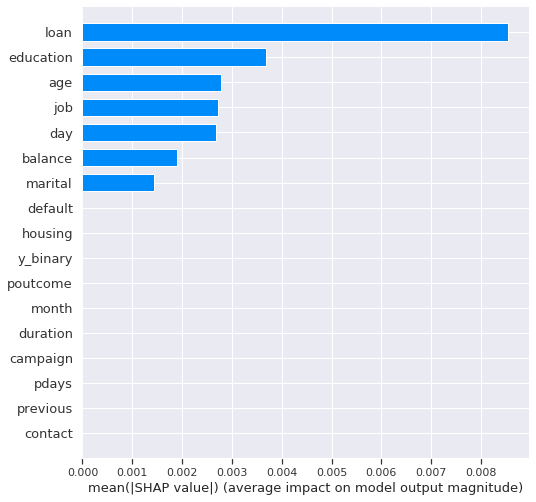

[array([-0.00278325, -0.00272845, -0.00143439,  0.00368277,  0.        ,
        0.00189623,  0.        , -0.00853272,  0.        , -0.00268837,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])]


In [27]:
shap_predictor = shap_predictor_factory(feature_names, example_model)
example_explainer = get_explainer(shap_predictor, dataframe)
example_shap_values = generate_explanation(example_explainer, dataframe, index_to_explain, example_model, chart=True, feature_names=feature_names)
print(example_shap_values)

In [28]:
instance_for_metrics = convert_dataframe_numpy(dataframe, index_to_explain)[0]

In [29]:
# Our external sensitivity metric shouldn't have to know about implementation of the explanation
def simple_explainer_factory(explainer, num_perturbations=NUM_PERTURBATIONS):
    def explainer_simple(this_instance):
        return explainer.shap_values(this_instance, nsamples=num_perturbations)[0]
    return explainer_simple

example_explainer_simple = simple_explainer_factory(example_explainer)

sensitivity = calculate_sensitivity(example_explainer_simple, example_shap_values, instance_for_metrics, metadata)
sensitivity

0.20115480257762855

In [30]:
print(example_shap_values)

[array([-0.00278325, -0.00272845, -0.00143439,  0.00368277,  0.        ,
        0.00189623,  0.        , -0.00853272,  0.        , -0.00268837,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])]


In [31]:
# Our fidelity function expects a model with a predict() attribute that just takes an array of numbers
class ModelForFidelity():
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
    def predict(self, instance):
        return predict_wrapper(self.model, [instance], self.feature_names)
    

fidelity_model = ModelForFidelity(example_model, feature_names)
infidelity = calculate_infidelity(example_shap_values[0], fidelity_model, instance_for_metrics, metadata)
infidelity

array([[2.0875561e-06]], dtype=float32)

### Overfitted model

Approach - try building models with 5 - 50 epochs (multiples of 5), with and without dropout. Compare metrics on TEST as well as training set. 

Hypothesis - models with higher epochs, and without dropout, will have higher accuracy on the training set but lower on test set. 

In [32]:
overfitting_results = pd.DataFrame(columns=['dropout', 'epochs', 'train_loss', 'train_accuracy', 'train_auc', 'test_loss', 'test_accuracy', 'test_auc'])


In [33]:
# With dropout
tf.get_logger().setLevel('ERROR')
for epochs in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50]:
    print(f'Calculating epoch: {epochs}')
    
    # With dropout
    model_with_dropout, history_with_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=True, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_with_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': True,
        'epochs': epochs,
        'train_loss': history_with_dropout.history['loss'][-1],
        'train_accuracy': history_with_dropout.history['accuracy'][-1],
        'train_auc': history_with_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)
    
    # Without dropout
    model_without_dropout, history_without_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=False, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_without_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': False,
        'epochs': epochs,
        'train_loss': history_without_dropout.history['loss'][-1],
        'train_accuracy': history_without_dropout.history['accuracy'][-1],
        'train_auc': history_without_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)


Calculating epoch: 1
91/91 [==============================] - 2s 4ms/step - loss: 0.2979 - accuracy: 0.8917 - precision: 0.6100 - recall: 0.1973 - auc: 0.7752
Calculating epoch: 2
91/91 [==============================] - 2s 7ms/step - loss: 0.2923 - accuracy: 0.8921 - precision: 0.6127 - recall: 0.2011 - auc: 0.7837
Calculating epoch: 3
91/91 [==============================] - 1s 6ms/step - loss: 0.2930 - accuracy: 0.8945 - precision: 0.6174 - recall: 0.2495 - auc: 0.7888
Calculating epoch: 4
91/91 [==============================] - 1s 6ms/step - loss: 0.2941 - accuracy: 0.8934 - precision: 0.6051 - recall: 0.2457 - auc: 0.7853
Calculating epoch: 5
91/91 [==============================] - 1s 5ms/step - loss: 0.2939 - accuracy: 0.8890 - precision: 0.5556 - recall: 0.2372 - auc: 0.7904
Calculating epoch: 6
91/91 [==============================] - 2s 7ms/step - loss: 0.2948 - accuracy: 0.8921 - precision: 0.6048 - recall: 0.2135 - auc: 0.7916
Calculating epoch: 7
91/91 [==================

In [34]:
overfitting_results

,dropout,epochs,train_loss,train_accuracy,train_auc,test_loss,test_accuracy,test_auc
0,True,1,0.322744,0.807678,0.714743,0.296517,0.892071,0.778458
1,False,1,0.310691,0.889806,0.756967,0.297906,0.891739,0.775233
2,True,2,0.299355,0.892115,0.772791,0.295827,0.892071,0.778804
3,False,2,0.290635,0.894105,0.790131,0.292314,0.892071,0.783698
4,True,3,0.292556,0.893303,0.787984,0.292458,0.892292,0.785158
5,False,3,0.284470,0.894935,0.801472,0.292951,0.894504,0.788759
6,True,4,0.289698,0.893829,0.790725,0.290548,0.892071,0.790959
7,False,4,0.278615,0.898418,0.812753,0.294137,0.893398,0.785288
8,True,5,0.286337,0.894990,0.799375,0.296302,0.892514,0.787010
9,False,5,0.273543,0.898059,0.821960,0.293894,0.888975,0.790366


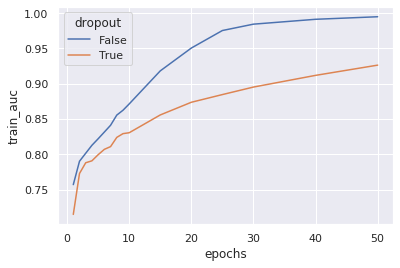

In [35]:
sns.lineplot(data=overfitting_results, x="epochs", y="train_auc", hue="dropout")

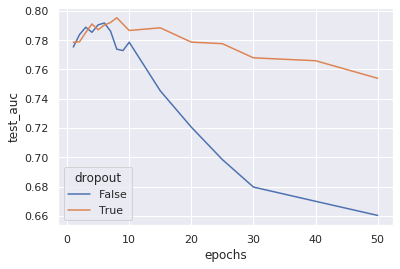

In [36]:
sns.lineplot(data=overfitting_results, x="epochs", y="test_auc", hue="dropout")

In [37]:
# Let's get some results!!
# Use 50 epochs x no dropout

# Remember - try changing the explanation. See how Fidelity increases. 

ovefitted_model, _ = create_fit_model(train_ds, input_layer, METRICS, epochs=50, dropout=False, verbose=0)

In [38]:
test_comparison = pd.DataFrame(columns=['model', 'prediction', 'instance_index', 'explanation', 'sensitivity', 'infidelity'])

In [40]:
# First 10 test instances

for idx in range(10):
    instance = convert_dataframe_numpy(test_df, idx)
    instance_for_metrics = instance[0]
    # YUCK ^
    regular_prediction = predict_wrapper(example_model, instance, feature_names)
    regular_shap_predictor = shap_predictor_factory(feature_names, example_model)
    regular_explainer = get_explainer(regular_shap_predictor, dataframe)
    regular_shap_values = generate_explanation(regular_explainer, dataframe, idx, example_model, chart=False, feature_names=feature_names)
    regular_simple_explainer = simple_explainer_factory(regular_explainer)
    regular_sensitivity = calculate_sensitivity(regular_simple_explainer, regular_shap_values, instance_for_metrics, metadata)
    regular_fidelity_model = ModelForFidelity(example_model, feature_names)
    regular_infidelity = calculate_infidelity(regular_shap_values[0], regular_fidelity_model, instance_for_metrics, metadata)
    test_comparison = test_comparison.append({
        'model': 'regular',
        'prediction': regular_prediction[0][0],
        'instance_index': idx,
        'explanation': regular_shap_values,
        'sensitivity': regular_sensitivity,
        'infidelity': regular_infidelity
    }, ignore_index=True)

    
    overfitted_prediction = predict_wrapper(ovefitted_model, instance, feature_names)
    overfitted_shap_predictor = shap_predictor_factory(feature_names, ovefitted_model)
    overfitted_explainer = get_explainer(overfitted_shap_predictor, dataframe)
    overfitted_shap_values = generate_explanation(regular_explainer, dataframe, idx, ovefitted_model, chart=False, feature_names=feature_names)
    overfitted_simple_explainer = simple_explainer_factory(overfitted_explainer)
    overfitted_sensitivity = calculate_sensitivity(overfitted_simple_explainer, overfitted_shap_values, instance_for_metrics, metadata)
    ovefitted_fidelity_model = ModelForFidelity(ovefitted_model, feature_names)
    ovefitted_infidelity = calculate_infidelity(overfitted_shap_values[0], ovefitted_fidelity_model, instance_for_metrics, metadata)
    test_comparison = test_comparison.append({
        'model': 'overfitted',
        'prediction': overfitted_prediction[0][0],
        'instance_index': idx,
        'explanation': overfitted_shap_values,
        'sensitivity': overfitted_sensitivity,
        'infidelity': ovefitted_infidelity
    }, ignore_index=True)

    

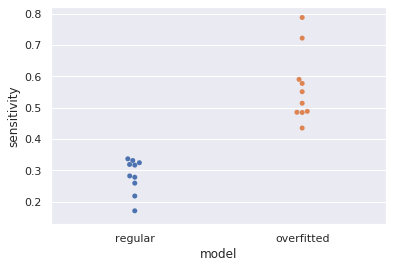

In [42]:
fig = plt.figure()
sns.swarmplot(x='model', y='sensitivity', data=test_comparison)

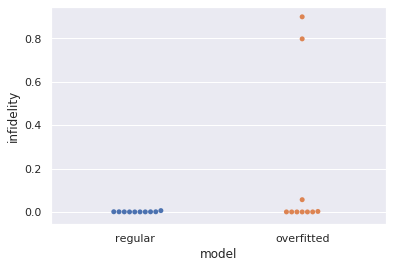

In [44]:
fig = plt.figure()
sns.swarmplot(x='model', y='infidelity', data=test_comparison)

In [ ]:
# TODO - what it i